In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
        GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

# 数据预处理：分割测试集和训练集

In [18]:

data = pd.read_csv('creditcard.csv')

train = data.sample(frac=0.8, random_state=1)
test = data.drop(train.index)
print(len(train), len(test))

train.to_csv('train_creditcard.csv', index=False)
test.to_csv('test_creditcard.csv', index=False)

227846 56961


# 数据分析. 基于 @zgzjdx

**************Training data statistics**************
Total num of data: 227846
Total type of features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
*****************************
                Time             V1             V2             V3  \
count  227846.000000  227846.000000  227846.000000  227846.000000   
mean    94700.896663       0.001815      -0.000309      -0.000356   
std     47517.061892       1.956585       1.652741       1.517925   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54097.250000      -0.918634      -0.597925      -0.888510   
50%     84609.000000       0.019943       0.064532       0.179583   
75%    139254.750000       1.315712       0.803148       1.027581   
max    172792.000000       2.454930      21.467203       9.382558   

                  V4          

d:\anaconda\envs\d2l-zh\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\anaconda\envs\d2l-zh\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


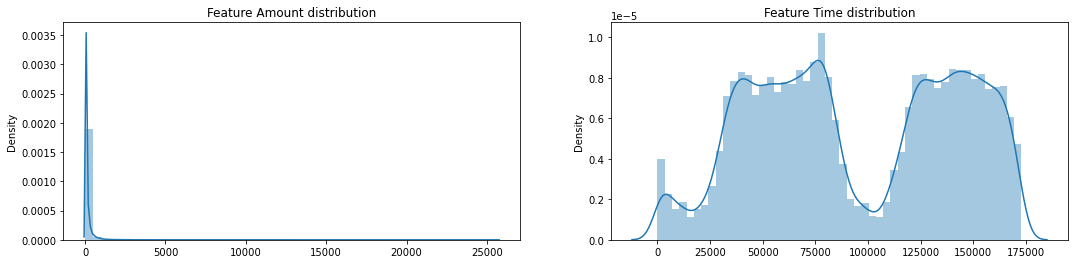

**************Test data statistics**************
Total num of data: 56961
Total type of features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
*****************************
                Time            V1            V2            V3            V4  \
count   56961.000000  56961.000000  56961.000000  56961.000000  56961.000000   
mean    95265.715191     -0.007261      0.001234      0.001423     -0.004292   
std     47370.027200      1.967118      1.645581      1.509568      1.415826   
min         0.000000    -41.928738    -44.639245    -29.468732     -4.934328   
25%     54636.000000     -0.927206     -0.601209     -0.896442     -0.856481   
50%     85199.000000      0.008446      0.070354      0.180827     -0.025544   
75%    139631.000000      1.315404      0.806543      1.026019      0.738416   
max    172788.000

d:\anaconda\envs\d2l-zh\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
d:\anaconda\envs\d2l-zh\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


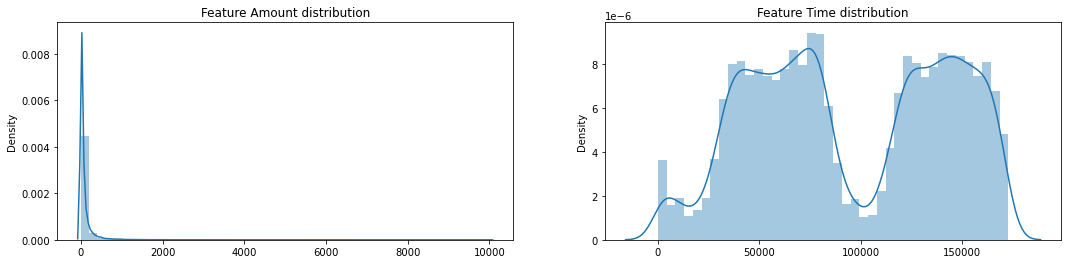

In [19]:

def csv_reader(file_name):
    data = pd.read_csv(file_name)
    print('Total num of data:', len(data))
    keys = [x for x in data]
    print('Total type of features:', keys)
    # calculate feature distribution
    print('*****************************')
    print(data.describe())
    data.describe().to_csv(file_name[:-4] + '_describe.csv')
    # calculate label distribution
    label_list = [row['Class'] for idx, row in data.iterrows()]
    print('Total num of label:', len(label_list))
    label_set = set(label_list)
    print('Label set:', label_set)
    print('Total type of label:', len(label_set))
    for label in label_set:
        print('Total num of {}: {}'.format(label, label_list.count(label)))
    # 可以发现什么结论？根据这种标签分布该如何取metrics？
    # 可视化部分
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    
    sns.distplot(data['Amount'].values, ax=ax[0])
    ax[0].set_title('Feature Amount distribution')

    sns.distplot(data['Time'].values, ax=ax[1])
    ax[1].set_title('Feature Time distribution')

    plt.show()
    return data

train_file_name = 'train_creditcard.csv'
print('**************Training data statistics**************')
train_df = csv_reader(train_file_name)
test_file_name = 'test_creditcard.csv'
print('**************Test data statistics**************')
test_df = csv_reader(test_file_name)

# 降采样

In [106]:
df = pd.read_csv('train_creditcard.csv')
train_df = pd.read_csv('train_creditcard.csv')
test_df = pd.read_csv('test_creditcard.csv')

rob_scaler = RobustScaler()

train_df['New Amount'] = rob_scaler.fit_transform(train_df['Amount'].values.reshape(-1, 1))
train_df['New Time'] = rob_scaler.fit_transform(train_df['Time'].values.reshape(-1, 1))
test_df['New Amount'] = rob_scaler.fit_transform(test_df['Amount'].values.reshape(-1, 1))
test_df['New Time'] = rob_scaler.fit_transform(test_df['Time'].values.reshape(-1, 1))

train_df.drop(['Amount', 'Time'], axis=1, inplace=True)
test_df.drop(['Amount', 'Time'], axis=1, inplace=True)

print(train_df.head())
print(test_df.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -0.611712 -0.769705 -0.149759 -0.224877  2.028577 -2.019887  0.292491   
1 -0.814682  1.319219  1.329415  0.027273 -0.284871 -0.653985  0.321552   
2 -0.318193  1.118618  0.969864 -0.127052  0.569563 -0.532484  0.706252   
3 -1.328271  1.018378  1.775426 -1.574193 -0.117696 -0.457733  0.681867   
4  1.276712  0.617120 -0.578014  0.879173  0.061706 -1.472002  0.373692   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0 -0.523020  0.358468  0.070050  ...  0.045536  0.380739  0.023440 -2.220686   
1  0.435975 -0.704298 -0.600684  ... -0.368565  0.090660  0.401147 -0.261034   
2 -0.064966 -0.463271 -0.528357  ... -0.774704 -0.123884 -0.495687 -0.018148   
3 -0.031641  0.383872  0.334853  ... -0.419013 -0.239197  0.009967  0.232829   
4 -0.287204 -0.084482 -0.696578  ... -0.430404 -0.076738  0.258708  0.552170   

        V26       V27       V28  Class  New Amount  New Time  
0 -0.

# 去除极端值(利用四分位距)

V11: 8


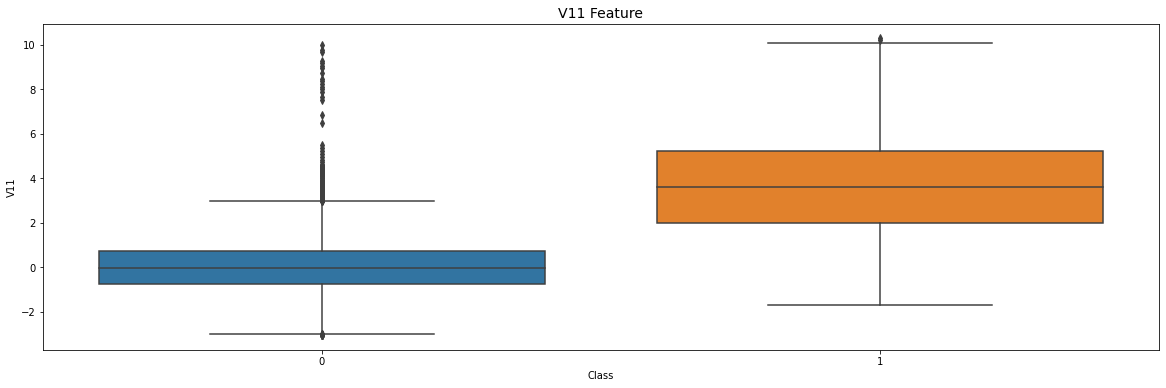

V12: 4


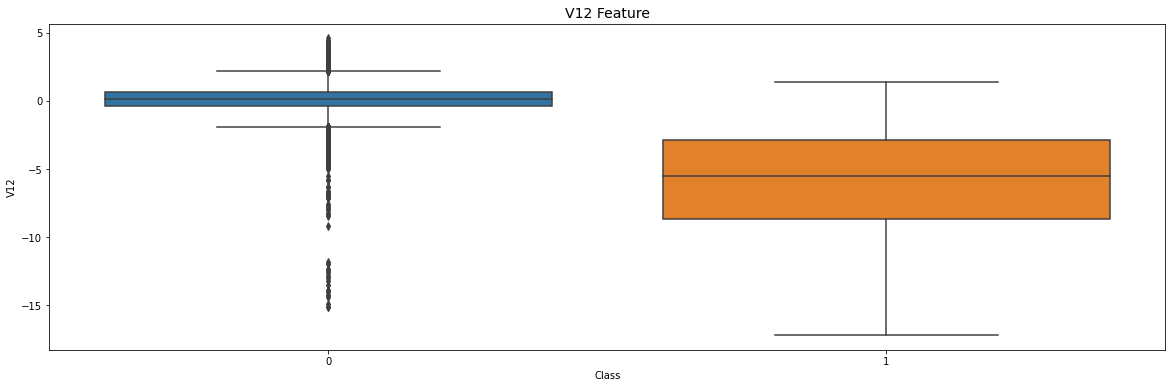

V15: 8


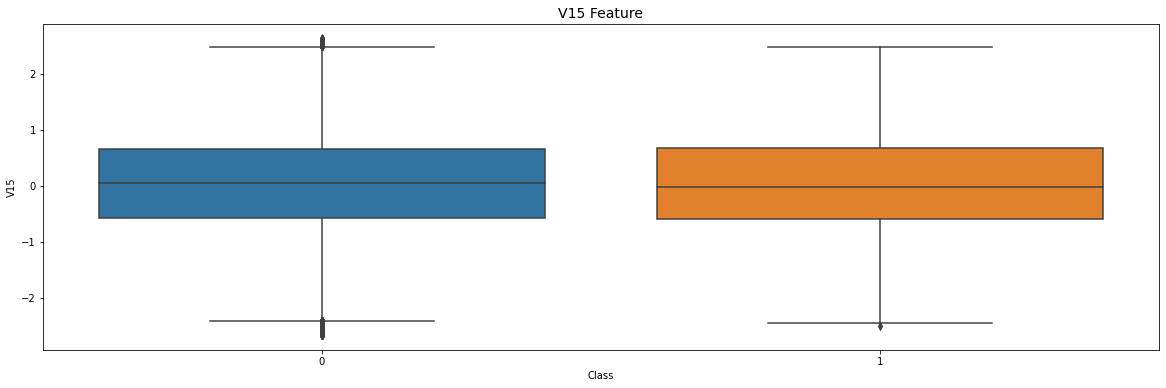

V19: 4


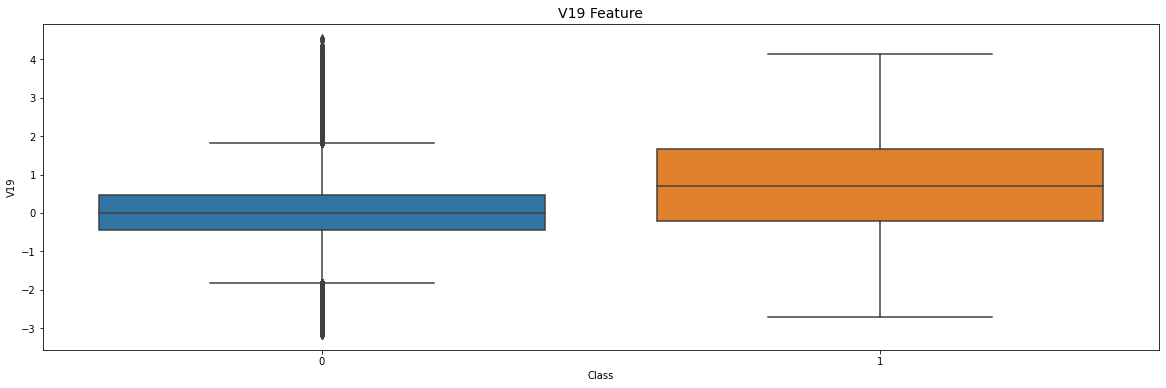

V24: 3


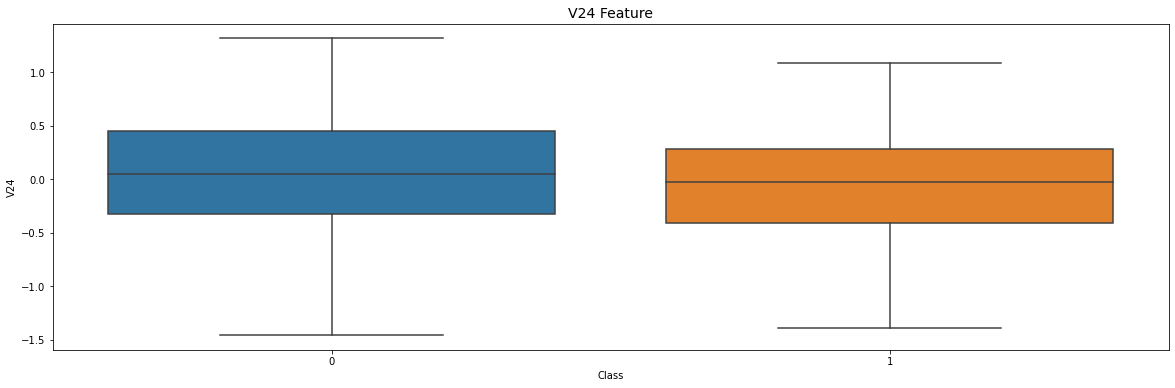

V26: 2


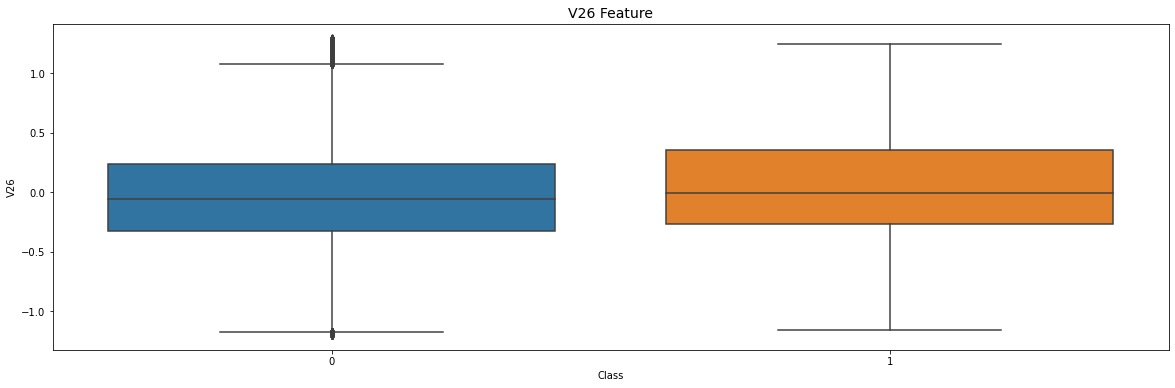

In [107]:
THRESHOLD = 10

for i in range(1, 29):
    name = "V" + str(i)
    
    fraud_val = train_df[train_df['Class'] == 1][name].values
    q1 = np.percentile(fraud_val, 25)
    q3 = np.percentile(fraud_val, 75)
    iqr = q3 - q1

    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    delete_val = [x for x in fraud_val if x < lower_bound or x > upper_bound]
    if len(delete_val) > 0 and len(delete_val) < THRESHOLD:
        print(name + ": " + str(len(delete_val)))
        train_df = train_df.drop(train_df[(train_df[name] < lower_bound) | (train_df[name] > upper_bound)].index)

        f, ax1 = plt.subplots(1, 1, figsize=(20,6))
        sns.boxplot(x="Class", y=name, data=train_df, ax=ax1)
        ax1.set_title(name + " Feature", fontsize=14)
        
        plt.show()

# 平衡 class 分布(1:4)

In [125]:
f_df = train_df.loc[train_df['Class'] == 1]
nf_df = train_df.loc[train_df['Class'] == 0].sample(frac=1, random_state=1)[:4*len(f_df)]
print(len(f_df), len(nf_df))
newtrain_df = pd.concat([f_df, nf_df])
newtrain_df = newtrain_df.sample(frac=1, random_state=1)

f_df = test_df.loc[test_df['Class'] == 1]
nf_df = test_df.loc[test_df['Class'] == 0].sample(frac=1, random_state=1)[:1*len(f_df)]
print(len(f_df), len(nf_df))
newtest_df = pd.concat([f_df, nf_df])
newtest_df = newtest_df.sample(frac=1, random_state=1)

369 1476
94 94


# 降维(!TODO)

In [126]:
X_train = newtrain_df.drop(['Class'], axis=1)
y_train = newtrain_df['Class']
X_test = newtest_df.drop(['Class'], axis=1)
y_test = newtest_df['Class']
print(len(y_test))

188


In [127]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'AdaBoost': AdaBoostClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Bagging': BaggingClassifier(),
    'Extra Trees': ExtraTreesClassifier()
}

In [128]:
print(len(classifiers))
best = 0
best_name = ''
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(key)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print('*****************************')
    if accuracy_score(y_test, y_pred) > best:
        best = accuracy_score(y_test, y_pred)
        best_name = key

10
Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        94
           1       0.99      0.90      0.94        94

    accuracy                           0.95       188
   macro avg       0.95      0.95      0.95       188
weighted avg       0.95      0.95      0.95       188

[[93  1]
 [ 9 85]]
*****************************
Random Forest
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        94
           1       1.00      0.87      0.93        94

    accuracy                           0.94       188
   macro avg       0.94      0.94      0.94       188
weighted avg       0.94      0.94      0.94       188

[[94  0]
 [12 82]]
*****************************
Naive Bayes
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        94
           1       0.98      0.85      0.91        94

    accuracy                       

In [129]:
print('Best classifier:', best_name)
print('Best accuracy:', best)

Best classifier: Decision Tree
Best accuracy: 0.9574468085106383
